In [15]:
# Baseline vs FE 결과를 시각화합니다.

# **필수 파일**
# - `outputs/compare_metrics.csv` (선택)
# - `outputs/pred_baseline.csv` (필수: 실제/예측)
# - `outputs/pred_fe.csv` (필수: 실제/예측)

# 예측 파일 컬럼: `전체코드`, `날짜`, `y_true`, `y_pred`
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["axes.unicode_minus"] = False  # 마이너스 깨짐 방지

In [16]:
# 비교 대상 확인
print(os.path.exists("outputs/pred_baseline.csv"), os.path.exists("outputs/pred_fe.csv"))

True True


In [17]:
# 경로 설정
PRED_BASELINE_PATH = "outputs/pred_baseline.csv"
PRED_FE_PATH       = "outputs/pred_fe.csv"
METRICS_PATH       = "outputs/compare_metrics.csv"  # 있으면 자동 로드

print("pred_baseline exists:", os.path.exists(PRED_BASELINE_PATH))
print("pred_fe       exists:", os.path.exists(PRED_FE_PATH))
print("metrics       exists:", os.path.exists(METRICS_PATH))


pred_baseline exists: True
pred_fe       exists: True
metrics       exists: True


In [18]:
# 데이터 로드
if not (os.path.exists(PRED_BASELINE_PATH) and os.path.exists(PRED_FE_PATH)):
    raise FileNotFoundError(
        "예측 파일이 없습니다. 03-1에서 아래 파일을 생성하세요:\n"
        f"- {PRED_BASELINE_PATH}\n- {PRED_FE_PATH}"
    )

pred_bl = pd.read_csv(PRED_BASELINE_PATH)
pred_fe = pd.read_csv(PRED_FE_PATH)

# 컬럼 검증
required_cols = {"전체코드", "날짜", "y_true", "y_pred"}
missing_bl = required_cols - set(pred_bl.columns)
missing_fe = required_cols - set(pred_fe.columns)
if missing_bl:
    raise ValueError(f"pred_baseline.csv에 필요한 컬럼이 없습니다: {missing_bl}")
if missing_fe:
    raise ValueError(f"pred_fe.csv에 필요한 컬럼이 없습니다: {missing_fe}")

pred_bl["날짜"] = pd.to_datetime(pred_bl["날짜"])
pred_fe["날짜"] = pd.to_datetime(pred_fe["날짜"])

pred_bl["전체코드"] = pred_bl["전체코드"].astype(str)
pred_fe["전체코드"] = pred_fe["전체코드"].astype(str)

display(pred_bl.head())
display(pred_fe.head())
print("rows:", len(pred_bl), len(pred_fe))


,전체코드,날짜,y_true,y_pred
0,1111010100,2023-12-30,149036.4655,215599.97
1,1111010100,2023-12-31,141937.5640,208448.22
2,1111010100,2024-01-01,139393.2260,208419.84
3,1111010100,2024-01-02,158631.0245,195297.66
4,1111010100,2024-01-03,157943.7065,199889.11


,전체코드,날짜,y_true,y_pred
0,1111010100,2024-01-06,144908.4935,151700.34
1,1111010100,2024-01-07,148767.0380,156257.38
2,1111010100,2024-01-08,168023.2640,159348.67
3,1111010100,2024-01-09,166342.5785,162194.11
4,1111010100,2024-01-10,157235.0965,164534.94


rows: 13514 6990


In [19]:
# 지표( MAE/RMSE ) 준비
# 1) metrics 파일이 있으면 우선 사용
if os.path.exists(METRICS_PATH):
    metrics = pd.read_csv(METRICS_PATH)
else:
    # 2) 없으면 pred 파일로부터 계산
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    metrics = pd.DataFrame([
        {
            "run": "baseline_weather_only",
            "MAE": mean_absolute_error(pred_bl["y_true"], pred_bl["y_pred"]),
            "RMSE": mean_squared_error(pred_bl["y_true"], pred_bl["y_pred"], squared=False),
            "test_rows": len(pred_bl),
            "n_features_raw": np.nan
        },
        {
            "run": "fe_weather_plus_lag_roll",
            "MAE": mean_absolute_error(pred_fe["y_true"], pred_fe["y_pred"]),
            "RMSE": mean_squared_error(pred_fe["y_true"], pred_fe["y_pred"], squared=False),
            "test_rows": len(pred_fe),
            "n_features_raw": np.nan
        },
    ])

metrics = metrics.copy()
metrics = metrics.sort_values("RMSE").reset_index(drop=True)
display(metrics)


,run,MAE,RMSE,train_rows,test_rows,n_features_raw
0,fe_weather_plus_lag_roll,14937.560624,42931.841032,120750,6990,12
1,baseline_weather_only,80262.580726,137869.031114,167894,13514,8


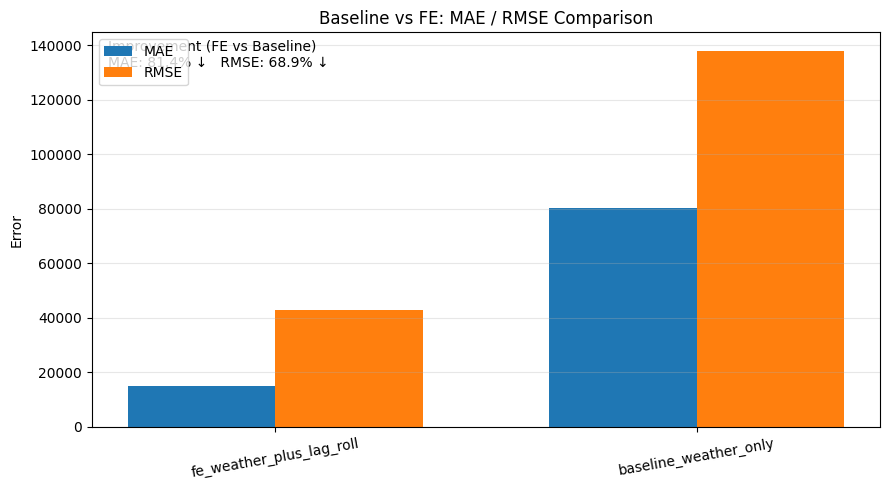

In [20]:
# 1) MAE/RMSE 막대 그래프
fig, ax = plt.subplots(figsize=(9, 5))
x = np.arange(len(metrics))
bar_w = 0.35

ax.bar(x - bar_w/2, metrics["MAE"].values, width=bar_w, label="MAE")
ax.bar(x + bar_w/2, metrics["RMSE"].values, width=bar_w, label="RMSE")

ax.set_xticks(x)
ax.set_xticklabels(metrics["run"].values, rotation=10)
ax.set_ylabel("Error")
ax.set_title("Baseline vs FE: MAE / RMSE Comparison")
ax.grid(axis="y", alpha=0.3)
ax.legend()

# 개선율 텍스트(가능하면 baseline/fe를 이름으로 식별)
def _pick_row(df, keyword):
    hits = df[df["run"].astype(str).str.contains(keyword, case=False, na=False)]
    return hits.iloc[0] if len(hits) else None

bl = _pick_row(metrics, "base")
fe = _pick_row(metrics, "fe")

if bl is not None and fe is not None:
    mae_improve = (bl["MAE"] - fe["MAE"]) / bl["MAE"] * 100
    rmse_improve = (bl["RMSE"] - fe["RMSE"]) / bl["RMSE"] * 100
    txt = f"Improvement (FE vs Baseline)\nMAE: {mae_improve:.1f}% ↓   RMSE: {rmse_improve:.1f}% ↓"
    ax.text(0.02, 0.98, txt, transform=ax.transAxes, va="top")

plt.tight_layout()
plt.show()


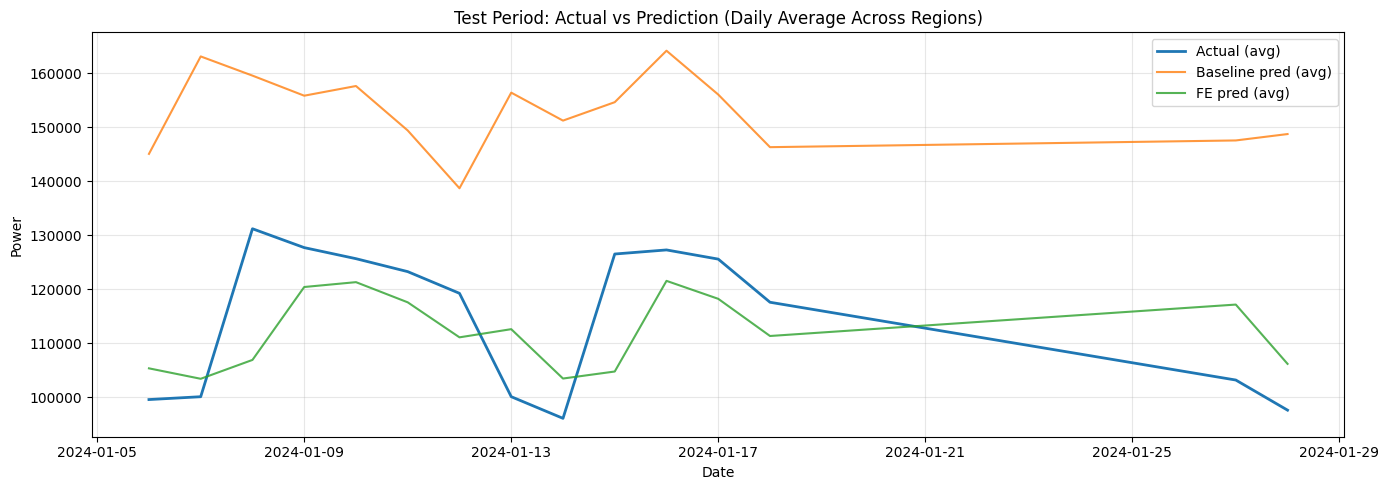

In [21]:
# 2) 테스트 기간: 일자별 평균 시계열(전체 지역 평균)
def daily_aggregate(pred_df: pd.DataFrame, how="mean"):
    g = pred_df.groupby("날짜")[["y_true", "y_pred"]]
    return (g.mean() if how == "mean" else g.sum()).reset_index()

agg_bl = daily_aggregate(pred_bl, how="mean")
agg_fe = daily_aggregate(pred_fe, how="mean")

# 공통 날짜만 비교
common_dates = np.intersect1d(agg_bl["날짜"].values, agg_fe["날짜"].values)
agg_bl = agg_bl[agg_bl["날짜"].isin(common_dates)].sort_values("날짜")
agg_fe = agg_fe[agg_fe["날짜"].isin(common_dates)].sort_values("날짜")

plt.figure(figsize=(14, 5))
plt.plot(agg_fe["날짜"], agg_fe["y_true"], label="Actual (avg)", linewidth=2)
plt.plot(agg_bl["날짜"], agg_bl["y_pred"], label="Baseline pred (avg)", alpha=0.8)
plt.plot(agg_fe["날짜"], agg_fe["y_pred"], label="FE pred (avg)", alpha=0.8)

plt.title("Test Period: Actual vs Prediction (Daily Average Across Regions)")
plt.xlabel("Date")
plt.ylabel("Power")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


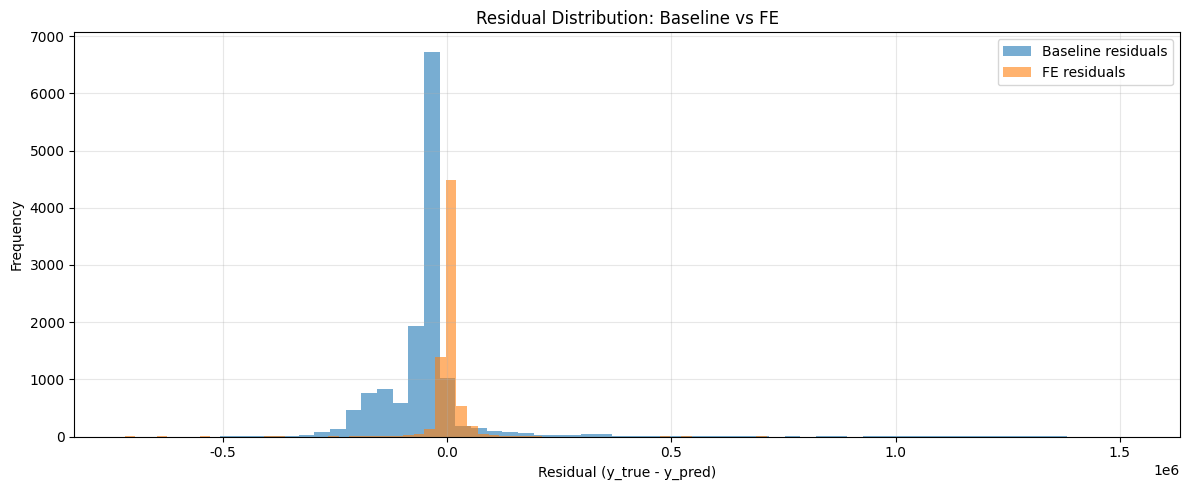

In [22]:
# 3) Residual(오차) 분포 비교
resid_bl = pred_bl["y_true"] - pred_bl["y_pred"]
resid_fe = pred_fe["y_true"] - pred_fe["y_pred"]

plt.figure(figsize=(12, 5))
plt.hist(resid_bl, bins=60, alpha=0.6, label="Baseline residuals")
plt.hist(resid_fe, bins=60, alpha=0.6, label="FE residuals")

plt.title("Residual Distribution: Baseline vs FE")
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


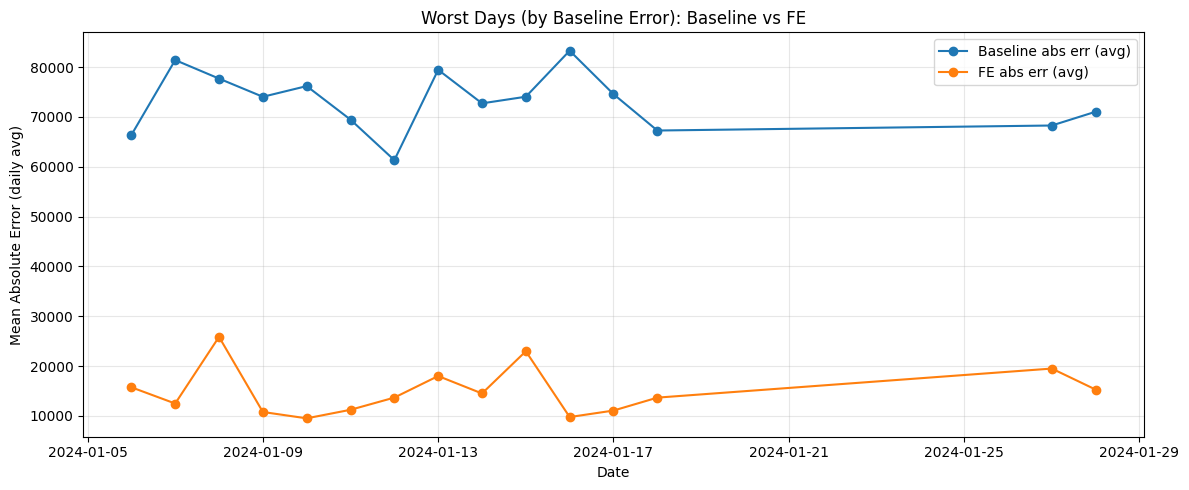

,날짜,abs_err_bl,abs_err_fe
0,2024-01-06,66366.483915,15745.042782
1,2024-01-07,81404.307175,12483.212933
2,2024-01-08,77686.690021,25858.856097
3,2024-01-09,74035.279951,10786.626479
4,2024-01-10,76180.511471,9511.559191
5,2024-01-11,69449.503774,11229.097231
6,2024-01-12,61321.563868,13675.449683
7,2024-01-13,79447.107072,18001.506242
8,2024-01-14,72717.563138,14502.570371
9,2024-01-15,74048.059569,22973.064595


In [23]:
# 4) Worst Days 비교 (Baseline 기준 상위 15일)
pred_bl2 = pred_bl.copy()
pred_fe2 = pred_fe.copy()

pred_bl2["abs_err"] = (pred_bl2["y_true"] - pred_bl2["y_pred"]).abs()
pred_fe2["abs_err"] = (pred_fe2["y_true"] - pred_fe2["y_pred"]).abs()

day_bl = pred_bl2.groupby("날짜")["abs_err"].mean().reset_index(name="abs_err_bl")
day_fe = pred_fe2.groupby("날짜")["abs_err"].mean().reset_index(name="abs_err_fe")
day_cmp = day_bl.merge(day_fe, on="날짜", how="inner")

worst = day_cmp.sort_values("abs_err_bl", ascending=False).head(15).sort_values("날짜")

plt.figure(figsize=(12, 5))
plt.plot(worst["날짜"], worst["abs_err_bl"], marker="o", label="Baseline abs err (avg)")
plt.plot(worst["날짜"], worst["abs_err_fe"], marker="o", label="FE abs err (avg)")

plt.title("Worst Days (by Baseline Error): Baseline vs FE")
plt.xlabel("Date")
plt.ylabel("Mean Absolute Error (daily avg)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

display(worst)


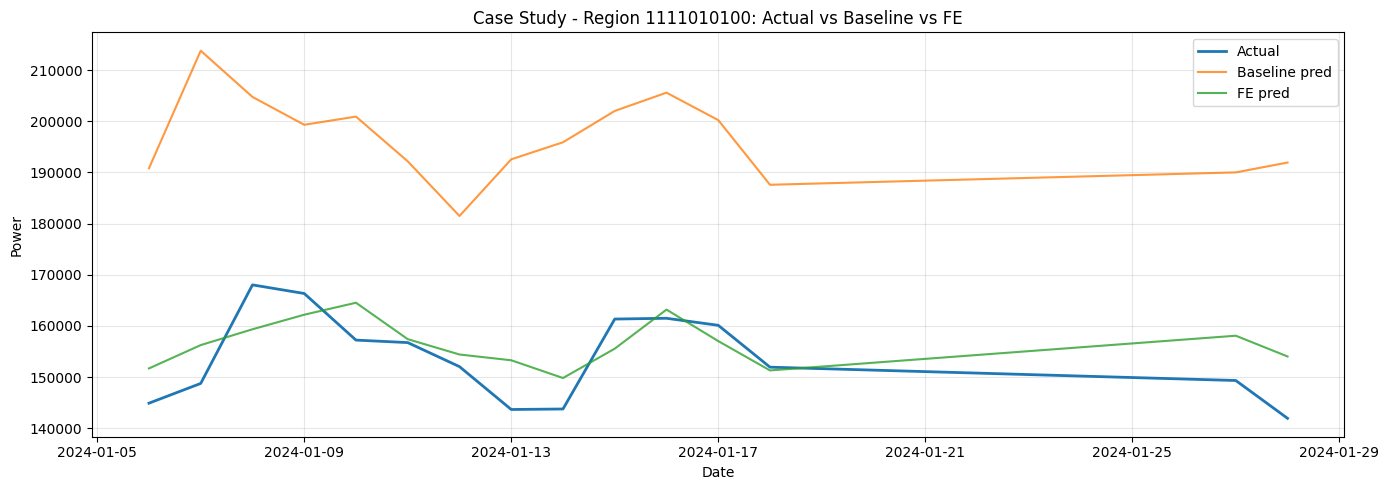

In [24]:
# 5) 단일 지역 사례 플롯 (데이터가 가장 많은 지역 1개)
top_code = pred_fe["전체코드"].value_counts().index[0]

one_bl = pred_bl[pred_bl["전체코드"] == top_code].sort_values("날짜")
one_fe = pred_fe[pred_fe["전체코드"] == top_code].sort_values("날짜")

m = one_bl[["날짜", "y_true", "y_pred"]].merge(
    one_fe[["날짜", "y_pred"]], on="날짜", suffixes=("_bl", "_fe")
)

plt.figure(figsize=(14, 5))
plt.plot(m["날짜"], m["y_true"], label="Actual", linewidth=2)
plt.plot(m["날짜"], m["y_pred_bl"], label="Baseline pred", alpha=0.8)
plt.plot(m["날짜"], m["y_pred_fe"], label="FE pred", alpha=0.8)

plt.title(f"Case Study - Region {top_code}: Actual vs Baseline vs FE")
plt.xlabel("Date")
plt.ylabel("Power")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
